# Minería de Datos (Master en Data Science, UIMP-UC)

## S17/T03. Intercomparación de técnicas de minería de datos 

### [Profesor: Rodrigo García Manzanas]    
#### Enero 2019

## Introducción

En esta práctica/tarea haremos una intercomparación de varias de las técnicas vistas a lo largo de la asignatura: CART, k-NN, GLMs y random forests. Por tanto, pretende ser un repaso general de cara al examen en el que el objetivo es tratar de entender las ventajas y limitaciones de las distintas técnicas para un caso de aplicación particular; la predicción de precipitación.

La entrega consisitirá de un notebook de Jupyter ó un R-MarkDown, junto con el archivo html que éste genera. Ambos ficheros se entregarán a través del Moodle de la asignatura en la tarea correspondiente.

Comenzaremos cargando el dataset `meteo`, que ya ha sido utilizado en sesiones anteriores. Como ya sabéis, la variable objetivo en este dataset es la precipitation diaria en Lisboa durante el período 1979-2008, y para predecirla se dispone de 320 predictores que describen la circulación de larga escala. Dichos predictores corresponden a un conjunto de 8 variables meteorológicas
* altura geopotencial en 500 hPa
* temperatura del aire en 850 hPa, 700 hPa, 500 hPa y superficie
* humedad específica del aire en 850 hPa y 500 hPa
* presión a nivel del mar

definidas sobre un dominio geográfico que incluye 40 puntos sobre la península Ibérica.

In [1]:
## loading data
rm(list = ls())
meteo <- read.csv(url(
    'https://raw.githubusercontent.com/SantanderMetGroup/Master-Data-Science/master/Data_mining/datasets/meteo.csv')
)

In [2]:
meteo$X <- NULL

In [3]:
#::GMG::Tengo el dataset completo (y + Xn ...)
head(x = meteo,n = 5)

y,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320
10.9,57042.96,56534.84,55884.40,55175.59,54458.21,56980.27,56460.59,55800.02,55051.15,⋯,101985.9,101627.3,101357.2,101110.7,101291.0,101814.9,101479.4,101164.5,100970.7,100905.3
0.6,56963.20,56493.45,55930.82,55340.20,54768.63,56856.57,56361.95,55776.76,55164.26,⋯,102048.1,102069.7,102204.5,102480.3,102858.8,101973.3,102033.3,102165.5,102323.9,102534.2
13.0,56522.59,55971.40,55304.34,54498.03,53725.15,56514.84,55977.71,55327.28,54569.78,⋯,102399.1,102448.4,102438.3,102434.3,102339.8,102669.7,102565.5,102530.3,102453.6,102487.1
0.0,54627.98,53979.80,53494.05,53072.98,52616.36,54776.17,54089.05,53516.98,53012.86,⋯,100970.0,100672.8,100360.7,100133.7,100028.4,101126.2,100700.0,100381.3,100118.3,100319.8
0.0,53584.38,53391.01,53310.38,53292.82,53340.13,53781.70,53498.13,53306.82,53213.26,⋯,100652.7,100663.5,100747.7,100934.0,101015.8,100801.6,100685.3,100777.5,100909.4,101164.7


Para agilizar los tiempos de cómputo, reduciremos la dimensionalidad de nuetro problema. Como ya se ha visto en sesiones anteriores, una alternativa para tal fin es el uso de PCs. Sin embargo, para no limitar la interpretabilidad de los resultados obtenidos con árboles, utilizaremos otra aproximación aquí. En concreto, optaremos por un análisis de correlaciones, en el que se calcula la correlación de Spearman entre nuestra variable objetivo y todas las variables predictoras disponibles. La idea es que, cuanto más fuerte sea esta correlación, mayor es el vínculo físico entre predictando y predictor, y por tanto, más útil es la información que nos aporta ese predictor. Por tanto, este análisis nos permite descartar predictores poco relevantes.
Siguiendo esta idea, calcularemos la correlación existente entre nuestro predictando y los 320 predictores, y eliminaremos aquellos con correlaciones entre -0.4 y 0.4. ¿Cuánto se ha reducido la dimensionalidad del problema?

In [4]:
## informed selection of predictors, based on a correlation analysis
# https://stats.stackexchange.com/questions/138860/is-using-correlation-matrix-to-select-predictors-for-regression-correct
# https://www.researchgate.net/post/Should_we_select_predicting_variables_simply_with_their_correlation_with_the_dependent_variable
# https://www.researchgate.net/post/How_to_refine_MaxEnt_model_by_removing_variables_that_are_highly_correlated
r.xy = c()
for (ivar in 2:ncol(meteo)) {
  r.xy[ivar] = cor(meteo$y, meteo[, ivar], method = "spearman")
}

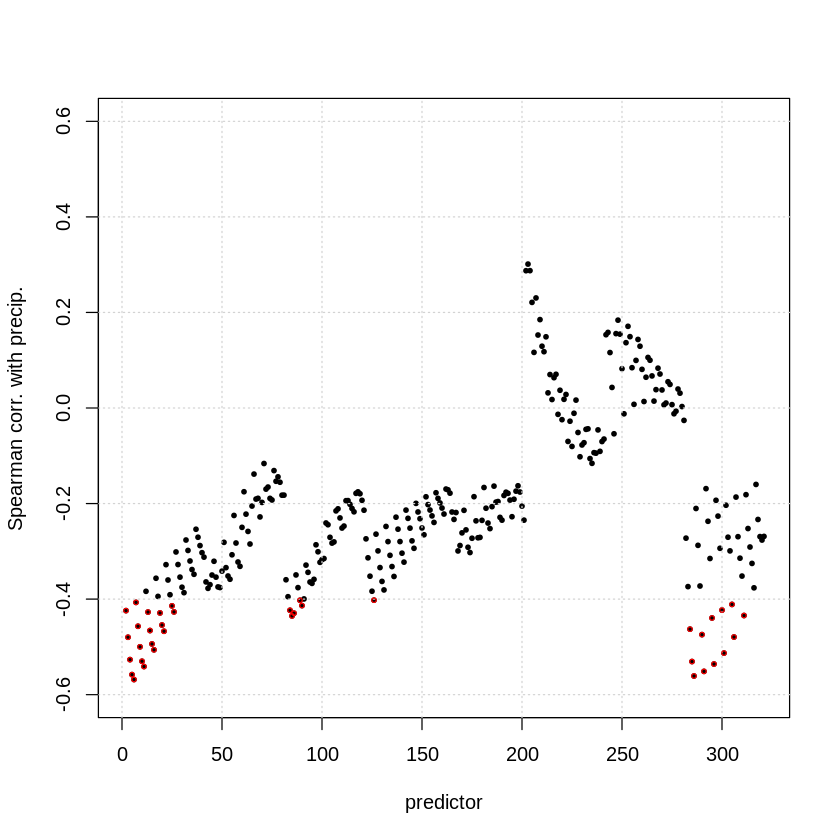

In [5]:
plot(r.xy, 
     ylim = c(-0.6, 0.6), 
     pch = 19, cex = 0.5, 
     xlab = "predictor", 
     ylab = "Spearman corr. with precip.")
grid()
ind.sele = which(abs(r.xy) > 0.4)
points(ind.sele, r.xy[ind.sele], col = "red", cex = 0.5)

In [6]:
meteo_spearman <- meteo[, ind.sele]

In [7]:
str(meteo_spearman)

'data.frame':	10958 obs. of  37 variables:
 $ X1  : num  57043 56963 56523 54628 53584 ...
 $ X2  : num  56535 56493 55971 53980 53391 ...
 $ X3  : num  55884 55931 55304 53494 53310 ...
 $ X4  : num  55176 55340 54498 53073 53293 ...
 $ X5  : num  54458 54769 53725 52616 53340 ...
 $ X6  : num  56980 56857 56515 54776 53782 ...
 $ X7  : num  56461 56362 55978 54089 53498 ...
 $ X8  : num  55800 55777 55327 53517 53307 ...
 $ X9  : num  55051 55164 54570 53013 53213 ...
 $ X10 : num  54319 54585 53863 52501 53157 ...
 $ X12 : num  56368 56187 55965 54205 53674 ...
 $ X13 : num  55721 55587 55360 53594 53378 ...
 $ X14 : num  54946 54947 54646 53021 53200 ...
 $ X15 : num  54145 54367 53999 52451 53055 ...
 $ X18 : num  55559 55360 55339 53657 53529 ...
 $ X19 : num  54788 54690 54720 53074 53260 ...
 $ X20 : num  53973 54125 54110 52486 53065 ...
 $ X24 : num  54555 54384 54695 53144 53383 ...
 $ X25 : num  53771 53843 54135 52556 53162 ...
 $ X83 : num  272 271 271 264 264 ...
 $ X84 

Para simplificar aún más los cálculos, nos limitaremos a los primeros 5000 días del dataset. Como siempre, consideraremos una partición de la muestra en dos subconjuntos independientes, train y test, escogidos aleatoriamente (75% para entrenar y 25% para validar).

In [8]:
# keeping only 5000 days for this example
n = 5000
y = meteo$y[1:n]
x = meteo_spearman[1:n,]

In [9]:
str(x)

'data.frame':	5000 obs. of  37 variables:
 $ X1  : num  57043 56963 56523 54628 53584 ...
 $ X2  : num  56535 56493 55971 53980 53391 ...
 $ X3  : num  55884 55931 55304 53494 53310 ...
 $ X4  : num  55176 55340 54498 53073 53293 ...
 $ X5  : num  54458 54769 53725 52616 53340 ...
 $ X6  : num  56980 56857 56515 54776 53782 ...
 $ X7  : num  56461 56362 55978 54089 53498 ...
 $ X8  : num  55800 55777 55327 53517 53307 ...
 $ X9  : num  55051 55164 54570 53013 53213 ...
 $ X10 : num  54319 54585 53863 52501 53157 ...
 $ X12 : num  56368 56187 55965 54205 53674 ...
 $ X13 : num  55721 55587 55360 53594 53378 ...
 $ X14 : num  54946 54947 54646 53021 53200 ...
 $ X15 : num  54145 54367 53999 52451 53055 ...
 $ X18 : num  55559 55360 55339 53657 53529 ...
 $ X19 : num  54788 54690 54720 53074 53260 ...
 $ X20 : num  53973 54125 54110 52486 53065 ...
 $ X24 : num  54555 54384 54695 53144 53383 ...
 $ X25 : num  53771 53843 54135 52556 53162 ...
 $ X83 : num  272 271 271 264 264 ...
 $ X84 :

In [10]:
str(y)

 num [1:5000] 10.9 0.6 13 0 0 1.2 1.1 0 0 0.7 ...


In [11]:
# train/test partition
indtrain = sample(1:n, round(0.75*n))  
indtest = setdiff(1:n, indtrain)

## Punto 1: Árboles de clasificación y regresión (CART)
### (2.5 puntos)

Como ya hemos visto en sesiones anteriores, tendremos que crear dos modelos independientes, uno para la clasificación del evento binario lluvia/no lluvia y otro para el evento continuo cantidad de lluvia.
Nos centramos en primer lugar en la clasificación lluvia/no lluvia. Para ello, tenemos que crear la variable binaria ocurrencia de precipitación (considera un umbral de 1mm) y construir el dataframe asociado al problema.

### Clasificación CART

#### Occurrence

In [12]:
#::GMG::binary occurrence
occurrence <- ifelse(y >= 1, 1, 0)
str(occurrence)

 num [1:5000] 1 0 1 0 0 1 1 0 0 0 ...


In [13]:
# dataframe for occurrence
df_occ <- cbind(occurrence,x)
str(df_occ)

'data.frame':	5000 obs. of  38 variables:
 $ occurrence: num  1 0 1 0 0 1 1 0 0 0 ...
 $ X1        : num  57043 56963 56523 54628 53584 ...
 $ X2        : num  56535 56493 55971 53980 53391 ...
 $ X3        : num  55884 55931 55304 53494 53310 ...
 $ X4        : num  55176 55340 54498 53073 53293 ...
 $ X5        : num  54458 54769 53725 52616 53340 ...
 $ X6        : num  56980 56857 56515 54776 53782 ...
 $ X7        : num  56461 56362 55978 54089 53498 ...
 $ X8        : num  55800 55777 55327 53517 53307 ...
 $ X9        : num  55051 55164 54570 53013 53213 ...
 $ X10       : num  54319 54585 53863 52501 53157 ...
 $ X12       : num  56368 56187 55965 54205 53674 ...
 $ X13       : num  55721 55587 55360 53594 53378 ...
 $ X14       : num  54946 54947 54646 53021 53200 ...
 $ X15       : num  54145 54367 53999 52451 53055 ...
 $ X18       : num  55559 55360 55339 53657 53529 ...
 $ X19       : num  54788 54690 54720 53074 53260 ...
 $ X20       : num  53973 54125 54110 52486 53065 

In [15]:
df_occ$occurrence <- as.factor(df_occ$occurrence)

In [16]:
str(df_occ)

'data.frame':	5000 obs. of  38 variables:
 $ occurrence: Factor w/ 2 levels "0","1": 2 1 2 1 1 2 2 1 1 1 ...
 $ X1        : num  57043 56963 56523 54628 53584 ...
 $ X2        : num  56535 56493 55971 53980 53391 ...
 $ X3        : num  55884 55931 55304 53494 53310 ...
 $ X4        : num  55176 55340 54498 53073 53293 ...
 $ X5        : num  54458 54769 53725 52616 53340 ...
 $ X6        : num  56980 56857 56515 54776 53782 ...
 $ X7        : num  56461 56362 55978 54089 53498 ...
 $ X8        : num  55800 55777 55327 53517 53307 ...
 $ X9        : num  55051 55164 54570 53013 53213 ...
 $ X10       : num  54319 54585 53863 52501 53157 ...
 $ X12       : num  56368 56187 55965 54205 53674 ...
 $ X13       : num  55721 55587 55360 53594 53378 ...
 $ X14       : num  54946 54947 54646 53021 53200 ...
 $ X15       : num  54145 54367 53999 52451 53055 ...
 $ X18       : num  55559 55360 55339 53657 53529 ...
 $ X19       : num  54788 54690 54720 53074 53260 ...
 $ X20       : num  53973 5

#### Árbol Completo

A continuación construiremos el árbol completo (usa la función *tree*).

**::GMG::** ¿Árbol completo? Es un árbol que clasifica perfectamente la muestra de entrenamiento (sobre el que haremos posteriormente un podado, i.e post-pruning) (s32 Overfitting: pruning the tree, presentación S07_ClassificationTrees)

**Nota**: según la documentación de [`tree.control`](https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/tree.control):

> To produce a tree that fits the data perfectly, set `mindev = 0` and `minsize = 2`, if the limit on tree depth allows such a tree.

In [17]:
library(tree)

In [19]:
set.seed(123)
#::GMG::Complete tree (tree)
tree_occ_cp <- tree(occurrence ~ ., 
                   subset= indtrain,
                   data = df_occ, mindev = 0, minsize = 2)

In [23]:
summary(tree_occ_cp)


Classification tree:
tree(formula = occurrence ~ ., data = df_occ, subset = indtrain, 
    mindev = 0, minsize = 2)
Number of terminal nodes:  291 
Residual mean deviance:  0 = 0 / 3459 
Misclassification error rate: 0 = 0 / 3750 

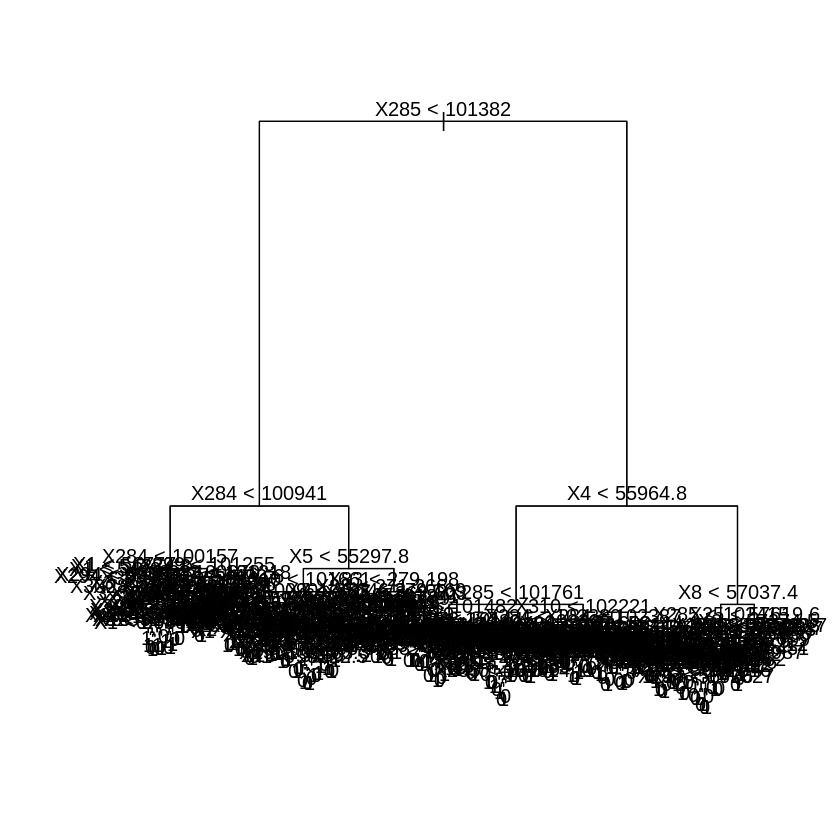

In [20]:
plot(tree_occ_cp)
text(tree_occ_cp, pretty = F)

**P1:** ¿Cuántos nodos terminales obtienes? 

In [21]:
#::GMG::count terminal nodes
# https://stackoverflow.com/questions/53208273/how-to-count-nodes-in-a-tree-in-r
paste('El número de nodos terminales es:', length(unique(tree_occ_cp$where)))

[1] "El número de nodos terminales es: 291"

**P2:** ¿Qué variables predictoras dan lugar a las primeras subdivisiones del árbol?

**::GMG::** X284, X285 y X4, X5, X8. Según la descripción del dataset son los valores de "Presión al nivel del mar" en dos localizaciones y  "Altura geopotencial en 500 hPa" en tres localizaciones, respectivamente.

**::nota::** 

    Altura geopotencial en 500 hPa (columnas 2:41),
    Temperatura del aire en 850 hPa (columnas 42:81), 700 hPa (columnas 82:121) y 500 hPa (columnas 122:161),
    Temperatura del aire en superficie (columnas 162:201),
    Humedad específica del aire en 850 hPa (columnas 202:241) y 500 hPa (columnas 242:281) y
    Presión al nivel del mar (columnas 282:321)

#### CV y Post-Pruning

Para simplificar este árbol tan complejo tendremos que podarlo adecuadamente. Utiliza una cross-validación con un 10-fold para encontrar el número de nodos terminales del árbol óptimo. ¿Cuál es este número? ¿Qué predictores aparecen como los más importantes?

In [22]:
#::GMG::Hago la cross-validation en el conjunto de train
## 10-fold cross-validation for determining optimum number of leaves
## pruning
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/cv.tree
cv_occ <- cv.tree(object = tree_occ_cp, FUN = prune.misclass, K = 10)

In [28]:
#::GMG::Datos que puedo ver del resultado de la Cross-validation
names(cv_occ)

[1] "size"   "dev"    "k"      "method"

In [29]:
#::GMG::Vemos el resultado de la cross-validation
cv_occ

$size
 [1] 291 271 263 258 252 167 155 146 132 113 110 106  99  91  66  61  47  41  35
[20]  29  18  13  10   9   7   6   3   1

$dev
 [1] 536 536 536 536 536 536 536 536 536 536 536 536 536 536 536 536 536 536 536
[20] 536 536 536 536 534 537 537 537 716

$k
 [1]        -Inf   0.5000000   0.7500000   0.8000000   0.8333333   1.0000000
 [7]   1.2500000   1.3333333   1.5000000   1.5789474   1.6666667   1.7500000
[13]   1.8571429   1.8750000   2.0000000   2.2000000   2.2857143   2.3333333
[19]   2.5000000   3.0000000   3.2727273   3.6000000   3.6666667   4.0000000
[25]   7.5000000  12.0000000  18.6666667 101.5000000

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

In [31]:
paste('El tamaño óptimo de hojas es:', cv_occ$size[which.min(cv_occ$dev)])

[1] "El tamaño óptimo de hojas es: 9"

In [33]:
#::GMG::Gráficamente
#plot(cv_occ$size, cv_occ$dev, type = "b")
#tree_min <- which.min(cv_occ$dev)
#points(tree_min, cv_occ$dev[tree_min], col = "red", cex = 2, pch = 20)

In [34]:
#::GMG:: Ahora lo podo
pruned_tree_occ <- prune.tree(tree_occ_cp, best = 9)

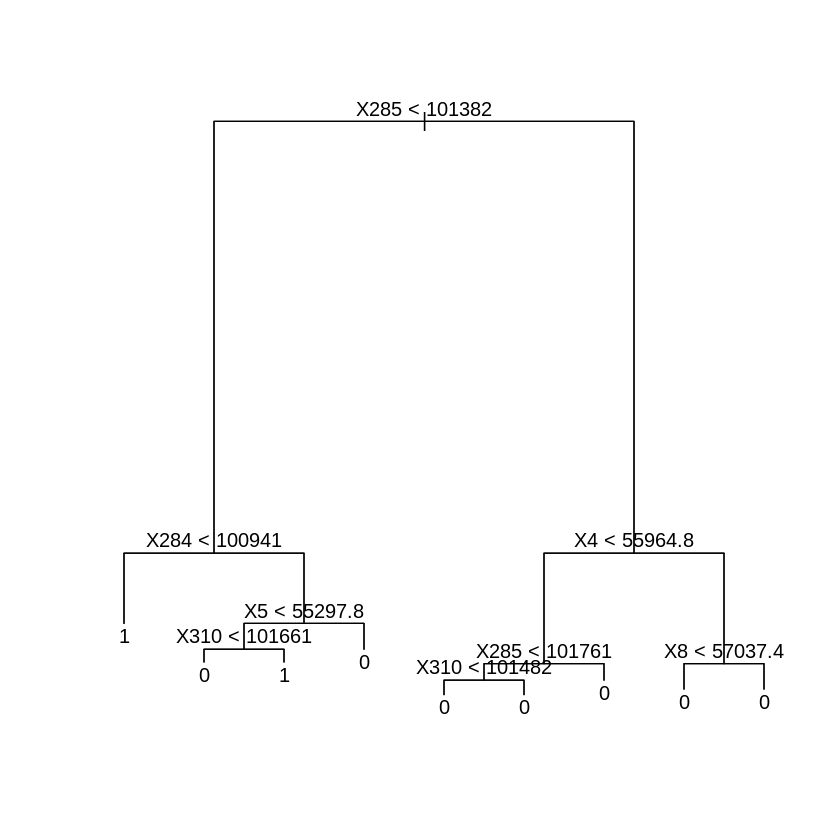

In [35]:
#::GMG::Visualizo el resultado
plot(pruned_tree_occ)
text(pruned_tree_occ, pretty = 0)

In [36]:
#::GMG::En el sumario se ven las variables que han sido utilizadas
summary(pruned_tree_occ)


Classification tree:
snip.tree(tree = tree_occ_cp, nodes = c(24L, 25L, 21L, 15L, 11L, 
4L, 20L, 13L, 14L))
Variables actually used in tree construction:
[1] "X285" "X284" "X5"   "X310" "X4"   "X8"  
Number of terminal nodes:  9 
Residual mean deviance:  0.6191 = 2316 / 3741 
Misclassification error rate: 0.1299 = 487 / 3750 

**::GMG::** Las variables más importantes que han sobrevivido a la poda: `X310`, `X284`, `X285`, `X4`, `X5`, `X8`. Según la descripción del dataset son los valores de "Presión al nivel del mar" en tres localizaciones y  "Altura geopotencial en 500 hPa" en tres localizaciones, respectivamente.

**::nota::** 

    Altura geopotencial en 500 hPa (columnas 2:41),
    Temperatura del aire en 850 hPa (columnas 42:81), 700 hPa (columnas 82:121) y 500 hPa (columnas 122:161),
    Temperatura del aire en superficie (columnas 162:201),
    Humedad específica del aire en 850 hPa (columnas 202:241) y 500 hPa (columnas 242:281) y
    Presión al nivel del mar (columnas 282:321)


#### Predicción (test)

Utiliza este árbol óptimo para predecir en el test. Guarda las predicciones.

In [38]:
#::GMG::Hago la predicción para el conjunto de test (occurrence prediction for test)
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/predict.tree
pred_occ <- predict(object = pruned_tree_occ, newdata = df_occ[indtest,], type="class")

In [39]:
str(pred_occ)

 Factor w/ 2 levels "0","1": 1 2 1 1 1 1 1 1 1 1 ...


### Regresión CART

#### Intensidad

Una vez obtenidas las predicciones de ocurrencia pasaremos a estimar la cantidad de precipitación. Primero creamos el dataset correspondiente.

In [42]:
#::GMG::Monto el dataset para amount
## dataframe for amount
#::nota::mantengo los índices de train/test
df_amount <- cbind(y,x)
str(df_amount)

'data.frame':	5000 obs. of  38 variables:
 $ y   : num  10.9 0.6 13 0 0 1.2 1.1 0 0 0.7 ...
 $ X1  : num  57043 56963 56523 54628 53584 ...
 $ X2  : num  56535 56493 55971 53980 53391 ...
 $ X3  : num  55884 55931 55304 53494 53310 ...
 $ X4  : num  55176 55340 54498 53073 53293 ...
 $ X5  : num  54458 54769 53725 52616 53340 ...
 $ X6  : num  56980 56857 56515 54776 53782 ...
 $ X7  : num  56461 56362 55978 54089 53498 ...
 $ X8  : num  55800 55777 55327 53517 53307 ...
 $ X9  : num  55051 55164 54570 53013 53213 ...
 $ X10 : num  54319 54585 53863 52501 53157 ...
 $ X12 : num  56368 56187 55965 54205 53674 ...
 $ X13 : num  55721 55587 55360 53594 53378 ...
 $ X14 : num  54946 54947 54646 53021 53200 ...
 $ X15 : num  54145 54367 53999 52451 53055 ...
 $ X18 : num  55559 55360 55339 53657 53529 ...
 $ X19 : num  54788 54690 54720 53074 53260 ...
 $ X20 : num  53973 54125 54110 52486 53065 ...
 $ X24 : num  54555 54384 54695 53144 53383 ...
 $ X25 : num  53771 53843 54135 52556 53162 

A continuación construiremos dos árboles, uno entrenado sobre todo el conjunto de train y otro entrenado sólo sobre los días de lluvia (en el train). 

#### Árbol Completo Train

Empezamos por el primero de estos árboles. Construye el árbol completo ¿Cuántos nodos terminales obtienes? ¿Qué variables predictoras dan lugar a las primeras subdivisiones del árbol? ¿Son las mismas que para el caso de la ocurrencia?

In [43]:
#::GMG::Construyo el árbol completo sobre todo el train (llueva o no)
## complete tree 1
#::nota::recordar lo que dice la documentación de tree.control para
#        poner bien los parámetros
tree_amount_all_cp <- tree(y ~ ., 
                   subset= indtrain,
                   data = df_amount, mindev = 0, minsize = 2)

In [44]:
summary(tree_amount_all_cp)


Regression tree:
tree(formula = y ~ ., data = df_amount, subset = indtrain, mindev = 0, 
    minsize = 2)
Number of terminal nodes:  916 
Residual mean deviance:  0.002809 = 7.96 / 2834 
Distribution of residuals:
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.2333000 -0.0059520 -0.0004155  0.0000000  0.0000000  0.3000000 

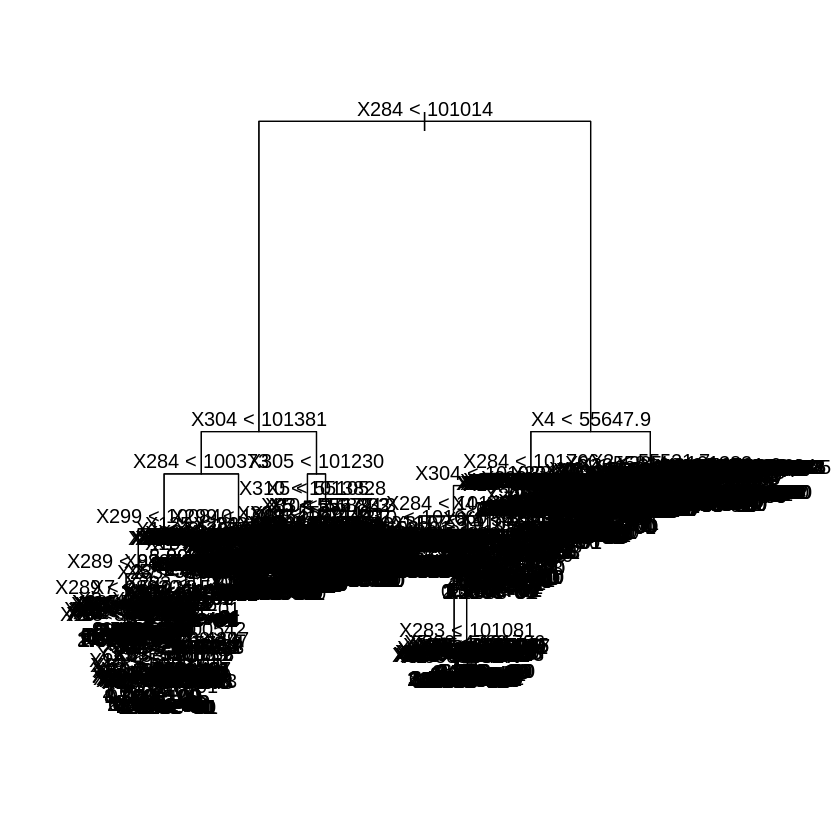

In [45]:
plot(tree_amount_all_cp)
text(tree_amount_all_cp, pretty = F)

In [46]:
paste('El número de nodos terminales es:', length(unique(tree_amount_all_cp$where)))

[1] "El número de nodos terminales es: 916"

**::GMG::** Las primeras subdivisiones del árbol usan las siguientes variables predictoras: X284, X289, X299, X304, X310 y X4. Según la descripción del dataset son los valores de "Presión al nivel del mar" en cinco localizaciones y  "Altura geopotencial en 500 hPa" en una localizacón, respectivamente. Parece que se ha dado más "peso" a la *presión a nivel del mar* en este caso.

**::nota::**:

    Altura geopotencial en 500 hPa (columnas 2:41),
    Temperatura del aire en 850 hPa (columnas 42:81), 700 hPa (columnas 82:121) y 500 hPa (columnas 122:161),
    Temperatura del aire en superficie (columnas 162:201),
    Humedad específica del aire en 850 hPa (columnas 202:241) y 500 hPa (columnas 242:281) y
    Presión al nivel del mar (columnas 282:321)


Al igual que hicimos para el caso de la ocurrencia, tendremos que podar este árbol tan complejo. Utiliza una cross-validación con un 10-fold para encontrar el número de nodos terminales del árbol óptimo. ¿Cuál es este número? ¿Qué predictores aparecen como los más importantes?

In [48]:
#::GMG::Hago la cross-validation en el conjunto de train
## 10-fold cross-validation for determining optimum number of leaves
## pruning
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/cv.tree
cv_amount <- cv.tree(object = tree_amount_all_cp, FUN = prune.tree, K = 10)

In [51]:
#::GMG::Datos que puedo ver del resultado de la Cross-validation
#names(cv_amount)
#::GMG::Vemos el resultado de la cross-validation
#cv_amount

In [53]:
paste('El tamaño óptimo de hojas es:', cv_amount$size[which.min(cv_amount$dev)])

[1] "El tamaño óptimo de hojas es: 6"

In [56]:
#::GMG:: Ahora lo podo
pruned_tree_amount_all <- prune.tree(tree_amount_all_cp, best = 6)

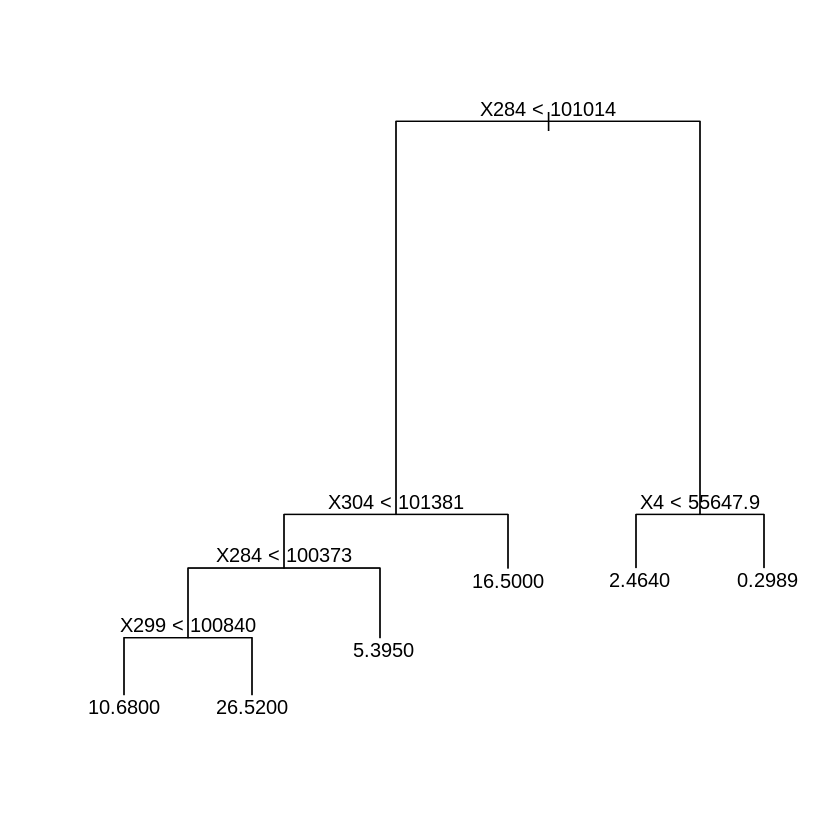

In [57]:
#::GMG::Visualizo el resultado
plot(pruned_tree_amount_all)
text(pruned_tree_amount_all, pretty = 0)

In [58]:
#::GMG::En el sumario se ven las variables que han sido utilizadas
summary(pruned_tree_amount_all)


Regression tree:
snip.tree(tree = tree_amount_all_cp, nodes = c(7L, 17L, 9L, 16L, 
5L, 6L))
Variables actually used in tree construction:
[1] "X284" "X304" "X299" "X4"  
Number of terminal nodes:  6 
Residual mean deviance:  22.81 = 85410 / 3744 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-26.4200  -1.2640  -0.2989   0.0000  -0.2989  93.0400 

**::GMG::** Las variables más importantes que han sobrevivido a la poda: `X304`, `X284`, `X299`, `X4`. Según la descripción del dataset son los valores de "Presión al nivel del mar" en tres localizaciones (se han caído dos tras la poda) y  "Altura geopotencial en 500 hPa" en una localización (se ha mantenido tras la poda), respectivamente.

**::nota::** 

    Altura geopotencial en 500 hPa (columnas 2:41),
    Temperatura del aire en 850 hPa (columnas 42:81), 700 hPa (columnas 82:121) y 500 hPa (columnas 122:161),
    Temperatura del aire en superficie (columnas 162:201),
    Humedad específica del aire en 850 hPa (columnas 202:241) y 500 hPa (columnas 242:281) y
    Presión al nivel del mar (columnas 282:321)


#### Predicción (test)

Utiliza el árbol óptimo que acabas de encontrar para predecir en el test, y conserva la predicción obtenida.

In [59]:
#::GMG::Hago la predicción para el conjunto de test (amount prediction for test)
# https://www.rdocumentation.org/packages/tree/versions/1.0-39/topics/predict.tree
pred_amount <- predict(object = pruned_tree_amount_all, 
                    newdata = df_amount[indtest,])

In [60]:
str(pred_amount)

 Named num [1:1250] 2.46 16.5 2.46 2.46 2.46 ...
 - attr(*, "names")= chr [1:1250] "1" "3" "5" "6" ...


#### Árbol completo (solo días de lluvia)

Repite el mismo proceso para el segundo árbol de regresión (el que sólo se entrena sobre los días de lluvia en el train).

In [63]:
length(which(occurrence == 1))

[1] 1011

In [72]:
dim(x[which(occurrence == 1),])

[1] 1011   37

In [ ]:
#::GMG::Ahora voy a usar solamente los días de lluvia
#::nota::los obtengo con la ocurrencia 
rainy <- y*occurrence

In [67]:
length(rainy[-which(rainy == 0)])

[1] 1011

In [65]:
df_rainy <- cbind(rainy, x[which(occurrence == 1),])

ERROR: Error in data.frame(..., check.names = FALSE): arguments imply differing number of rows: 5000, 1011


In [ ]:
str(df_rainy)

In [ ]:
## complete tree 2 (trained only on rainy days)

## 10-fold cross-validation for determining optimum number of leaves

## pruning

m1966 - práctica entregable de repaso (S17-T03):

## amount prediction for test

Obtén las dos series predichas completas para el test (la secuencia lluvia/no lluvia será la misma en las dos) y valida tus resultados en función de las siguiente métricas: 
* Para la parte binaria lluvia/no lluvia: Accuracy.
* Para la serie completa: RMSE, correlación de Spearman y ratio de varianzas.

In [ ]:
## final prediction

In [ ]:
## validation

# accuracy 
# RMSE (tree 1, tree 2)
# correlation (tree 1, tree 2)
# ratio of variances (tree 1, tree 2)

**Pregunta:** ¿Cuál de los dos árboles da mejores resultados? ¿Por qué?

# Random forests
### (2.5 puntos)

A continuación vamos a realizar el mismo ejercicio pero sustituyendo árboles individuales por random forests. 
Empecemos con el evento ocurrencia. Para estimar cuál sería el tamaño óptimo de nuestro random forest, prueba bosques de hasta 1000 árboles (utiliza la función *randomForest*) y plotea los errores Out-Of-Bag (OOB). ¿Con cuántos árboles te quedarías?

**Nota:** Hemos visto en la teoría que además del número de árboles, el otro parámetro a ajustar en los random forests es el número de predictores que se consideran en cada nodo para el splitting. En esta práctica/tarea utlizaremos los valores típicos; *sqrt(n)* en problemas de clasificación y *n/3* en problemas de predicción (siendo *n* el número total de predictores disponibles). 

In [ ]:
# RF for occurrence (up to 1000 trees)

Utiliza el bosque de tamaño óptimo parar predecir la ocurrencia en el test, y conserva la predicción.

In [ ]:
## RF for occurrence (optimum)

## occurrence prediction for test

Seguidamente, tal y como hicimos con los árboles individuales, vamos a crear dos random forests para la cantidad, uno que se entrene sobre todo el dataset de train y otro que se entrene sólo sobre los días de lluvia (en el train). De nuevo, tendrás que estimar cuál es el número óptimo de árboles en cada uno de ellos (prueba bosques de hasta 1000 árboles). ¿Qué tamaños óptimos obtienes?

In [ ]:
## RF 1 for amount (up to 1000 trees)

## RF 2 for amount (up to 100 trees)

# plotting OOB errors

Utiliza los bosques óptimos encontrados para predecir la cantidad en el test, y conserva las predicciones obtenidas.

In [ ]:
## RF 1 for amount (optimum)

# amount prediction for test

## RF 2 for amount (optimum)

# amount prediction for test 

Construye las predicciones completas (ocurrencia * cantidad) de test y valídalas en función de las mismas métricas utilizadas en el apartado anterior.

In [ ]:
# predictions for test

# validation

**Pregunta:** Compara estos resultados con los obtenidos para árboles individuales. ¿Qué conclusiones obtienes de la comparación entre árboles individuales y random forests?

## Modelos lineales generalizados (GLMs)
### (1.5 puntos)

Usaremos a continuación GLMs para el mismo problema abordado en los apartados anteriores. Como ya hemos visto en otras sesiones, debemos utilizar la familia *binomial* con función de enlace *logit* (regresión logística) para clasificación y la familia *Gamma* con función de enlace *log* para la cantidad. 

Comenzamos con el modelo para la ocurrencia.

In [ ]:
## GLM for occurrence

Una vez tenemos el modelo, lo utilizamos para predecir en el test. Tendremos que convertir la predicción probabilística obtenida en binaria (considera un umbral 0.5).

In [ ]:
## occurrence prediction for test

A continuación, ajustamos el modelo de cantidad. Para ello tenemos que seleccionar previamente los días de lluvia (la familia Gamma sólo acepta valores positivos). 

In [ ]:
## GLM for amount

Utilizamos el modelo obtenido para predecir la cantidad en el test.

In [ ]:
## amount prediction for test

De nuevo, multiplicamos la ocurrencia por la cantidad para obtener la predicción completa en el test y la validamos en función de las métricas de validación que utilizamos para CART y random forests.

In [ ]:
# final prediction for test

# validation

**Pregunta:** Compara estos resultados con los obtenidos para CART y random forests. ¿Qué conclusiones obtienes?

## k nearest neighbors (k-NN)
### (1.5 puntos)

La última de las técnicas a utilizar será la k-NN (ten en cuenta que en este caso ya no tendremos que predecir por separado ocurrencia y cantidad). Comenzaremos por una versión de k-NN en la que sólo se considere el vecino más cercano (utiliza la función *knn.reg* del paquete *FNN*). 

**Nota:** Recuerda que en la técnica k-NN es muy importante pre-procesar adecuadamente (estandarizar) los predictores.

In [ ]:
## prediction for test (with k = 1)

Como vimos en su día, el único parámetro a ajustar en la técnica k-NN es k (número de vecinos). Utilizaremos el paquete *caret* para encontrar el k óptimo en nuestro problema. Para ello, considera una cross-validación con 10 folds sobre el dataset de train y barre todos los k impares desde 1 a 50.

In [ ]:
library(caret)
## finding optimum k

Utiliza este *k* óptimo para predecir en el test.

In [ ]:
# prediction for test (with optimum k)

Valida las dos predicciones (con *k=1* y con *k=óptimo*) en el test, en función de las medidas que se han ido utilizando en los apartados anteriores.

In [ ]:
# validation

**Pregunta:** ¿Qué diferencias obtienes entre las dos versiones utilizadas de la técnica k-NN? ¿A qué se deben?

## Conclusiones generales
### (2 puntos)
A la vista de los resultados obtenidos, argumenta razonadamete qué técnica o técnicas serían las mejores para la predicción de lluvia en Lisboa. Justifica tu respuesta.